# THOMAS MCDONNELL QTS HW 5: FX CARRY TRADE

In [292]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
from plotnine import *
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from pandas import DateOffset
import patchworklib as pw

import warnings

# Suppress the warning
warnings.filterwarnings("ignore")

<Figure size 100x100 with 0 Axes>

In [261]:
#Overnight Swaps Data
ois = quandl.get('YC/GBR_ISSC', api_key = 'uoxc6V3s61czWuHoGLcs')
part2 = quandl.get('YC/GBR_ISSS', api_key = 'uoxc6V3s61czWuHoGLcs')
ois = pd.concat([ois, part2])
ois
gbp_yc = ois[['5.0Y']]
ois = ois[['0.08Y']]
ois/=100
gbp_yc/= 100

In [262]:
ois = ois.drop_duplicates().resample("W-WED").ffill()
idx = gbp_yc.drop_duplicates().resample("W-WED").asfreq().index
gbp_yc = gbp_yc.drop_duplicates().reindex(gbp_yc.index.union(idx)).ffill().resample("W-WED").first().dropna()
#Got help with this function for madison

In [263]:
#FX Rates Data
vnd = quandl.get("CUR/VND", authtoken="uoxc6V3s61czWuHoGLcs")
thb = quandl.get("CUR/THB", authtoken="uoxc6V3s61czWuHoGLcs")
pkr = quandl.get("CUR/PKR", authtoken="uoxc6V3s61czWuHoGLcs")
php = quandl.get("CUR/PHP", authtoken="uoxc6V3s61czWuHoGLcs")
gbp = quandl.get("CUR/GBP", authtoken="uoxc6V3s61czWuHoGLcs")

In [264]:
#Yield Curve Data
vnd_yc = quandl.get("YC/VNM", authtoken="uoxc6V3s61czWuHoGLcs")
thb_yc = quandl.get("YC/THA", authtoken="uoxc6V3s61czWuHoGLcs")
pkr_yc = quandl.get("YC/PAK", authtoken="uoxc6V3s61czWuHoGLcs")
php_yc = quandl.get("YC/PHL", authtoken="uoxc6V3s61czWuHoGLcs")

vnd_yc /= 100
thb_yc /= 100
pkr_yc /= 100
php_yc /= 100

vnd_yc = vnd_yc.resample("W-WED").ffill()
thb_yc = thb_yc.resample("W-WED").ffill()
pkr_yc = pkr_yc.resample("W-WED").ffill()
php_yc = php_yc.resample("W-WED").ffill()

vnd_yc.columns= [1,2,3,5,7,10,15]
vnd_yc = vnd_yc[[1,2,3,5]]

php_yc.columns = [.08,.25,.5,1,2,3,4,5,7,10,20,25]
php_yc = php_yc[[1,2,3,4,5]]

pkr_yc.columns = [.25,.5,1,3,5,10]
pkr_yc = pkr_yc[[1,3,5]]

thb_yc.columns = [.08,.25,.5,1,2,3,4,5,6,7,8,9,10,15]
thb_yc = thb_yc[[1.00,2.00,3.00,4.00,5.00]]

vnd_yc =vnd_yc.loc[pd.to_datetime('2014-12-03'):pd.to_datetime('2023-01-01')]
thb_yc =thb_yc.loc[pd.to_datetime('2014-12-03'):pd.to_datetime('2023-01-01')]
pkr_yc =pkr_yc.loc[pd.to_datetime('2014-12-03'):]
php_yc =php_yc.loc[pd.to_datetime('2014-12-03'):pd.to_datetime('2023-01-1')]


In [265]:
#Functions 
def spot_rate(zcb, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        sr = None
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        coupons_pv_x = 0.5*np.exp(-r*times).sum()
        final_pv = np.exp(-tenor*r[-1])
        sr = (1.0 - final_pv) / coupons_pv_x # Solves x + c * delta = 1.0
    return sr
def compute_spot_rates(zcb_rates):
    spot = zcb_rates.copy()
    for curve in zcb_rates.columns:
        zcb = zcb_rates[curve]
        for tenor, rate in zcb.iteritems():
            if tenor>0.001:
                spot[curve][tenor] = spot_rate(zcb, tenor)
    return spot
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.25)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.25 * coupon_rate * np.exp(-r*times).sum()
    return p
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.25, 0, step=-0.25)[::-1]
                coupon_half_yr = 0.25*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates

In [266]:
#get zcb curves
vnd_zero_cp_bond_dict ={}
for i in range(len(vnd_yc)):
    x = vnd_yc.iloc[i].to_frame()
    x.index.name = 'Tenor'
    vnd_zero_cp_bond_dict[x.columns[0]] = compute_zcb_curve(x)

thb_zero_cp_bond_dict ={}
for i in range(len(thb_yc)):
    x = thb_yc.iloc[i].to_frame()
    x.index.name = 'Tenor'
    thb_zero_cp_bond_dict[x.columns[0]] = compute_zcb_curve(x)

php_zero_cp_bond_dict ={}
for i in range(len(php_yc)):
    x = php_yc.iloc[i].to_frame()
    x.index.name = 'Tenor'
    php_zero_cp_bond_dict[x.columns[0]] = compute_zcb_curve(x)

pkr_zero_cp_bond_dict ={}
for i in range(len(pkr_yc)):
    x = pkr_yc.iloc[i].to_frame()
    x.index.name = 'Tenor'
    pkr_zero_cp_bond_dict[x.columns[0]] = compute_zcb_curve(x)

In [267]:
#turning everything into transposed DFs

vnd_zcb_df = pd.concat(vnd_zero_cp_bond_dict, axis=1)
vnd_zcb_df.columns = vnd_zero_cp_bond_dict.keys()
vnd_zcb_df = vnd_zcb_df.T

thb_zcb_df = pd.concat(thb_zero_cp_bond_dict, axis=1)
thb_zcb_df.columns = thb_zero_cp_bond_dict.keys()
thb_zcb_df = thb_zcb_df.T

pkr_zcb_df = pd.concat(pkr_zero_cp_bond_dict, axis=1)
pkr_zcb_df.columns = pkr_zero_cp_bond_dict.keys()
pkr_zcb_df = pkr_zcb_df.T

php_zcb_df = pd.concat(php_zero_cp_bond_dict, axis=1)
php_zcb_df.columns = php_zero_cp_bond_dict.keys()
php_zcb_df = php_zcb_df.T

In [268]:
pkr_yc

Tenor,1.0,3.0,5.0
Date,,,
2014-12-03,0.0964,0.1043,0.1088
2014-12-10,0.0964,0.1030,0.1072
2014-12-17,0.0964,0.1030,0.1072
2014-12-24,0.0964,0.1030,0.1072
2014-12-31,0.0964,0.1030,0.1072
...,...,...,...
2020-03-04,0.1360,0.1268,0.1230
2020-03-11,0.1360,0.1268,0.1230
2020-03-18,0.1360,0.1268,0.1230


In [346]:
def carry_trade(currency_zcb, currency_yc, currency_fx):
    notional = 10_000_000
    leveraged_capital = 8_000_000
    trades =(currency_yc[5.0] - gbp_yc['5.0Y'] + 0.005).dropna().to_frame()
    x = pd.DataFrame(index = currency_zcb.index, columns = ['borrowed', 'returned','interest paid', 'total borrowing pnl','lending pnl', 'pnl'])
    for i in range(len(trades)-1):
        if currency_zcb.iloc[i].to_frame().columns[0].day_name() == 'Wednesday':
            if trades[0][i] > 0:
                #borrowed
                borrow_rate = (ois['0.08Y'][currency_zcb.iloc[i].to_frame().columns[0]]+0.005)/52
                borrowed_gbp = gbp.loc[currency_zcb.iloc[i].to_frame().columns[0]]['RATE']*leveraged_capital
                interest_paid = borrow_rate*borrowed_gbp/gbp.loc[currency_zcb.iloc[i+1].to_frame().columns[0]]['RATE']
                x['interest paid'][currency_zcb.iloc[i+1].to_frame().columns[0]]= interest_paid
                borrowed = 8_000_000
                returned  = borrowed * gbp['RATE'][currency_zcb.iloc[i].to_frame().columns[0]]/gbp['RATE'][currency_zcb.iloc[i+1].to_frame().columns[0]]
                x['borrowed'][currency_zcb.iloc[i+1].to_frame().columns[0]] = borrowed
                x['returned'][currency_zcb.iloc[i+1].to_frame().columns[0]] = returned
                

                #Lending
                lended_curr = notional * currency_fx.loc[currency_zcb.iloc[i].to_frame().columns[0]]['RATE']
                initial_price_of_bond = bond_price(currency_zcb.iloc[i], currency_yc.iloc[i][5], 5)
                final_price_of_bond = bond_price(currency_zcb.iloc[i+1], currency_yc.iloc[i][5], 4.9807)
                price_difference = lended_curr*final_price_of_bond - lended_curr*initial_price_of_bond
                price_difference_usd = (lended_curr + price_difference)/currency_fx.loc[currency_zcb.iloc[i+1].to_frame().columns[0]]['RATE']
                x['lending pnl'][currency_zcb.iloc[i+1].to_frame().columns[0]] = price_difference_usd-10_000_000
    x['total borrowing pnl'] = x['borrowed'] - x['returned'] - x['interest paid']
    x['pnl'] = x['total borrowing pnl'] + x['lending pnl']
    x['cumulative pnl'] = x['pnl'].cumsum()
    x = x.dropna()
    return x


In [347]:
THB_Carry = carry_trade(thb_zcb_df,thb_yc, thb)
VND_Carry = carry_trade(vnd_zcb_df,vnd_yc, vnd)
PHP_Carry = carry_trade(php_zcb_df,php_yc, php)
PKR_Carry = carry_trade(pkr_zcb_df,pkr_yc, pkr)

Analysis

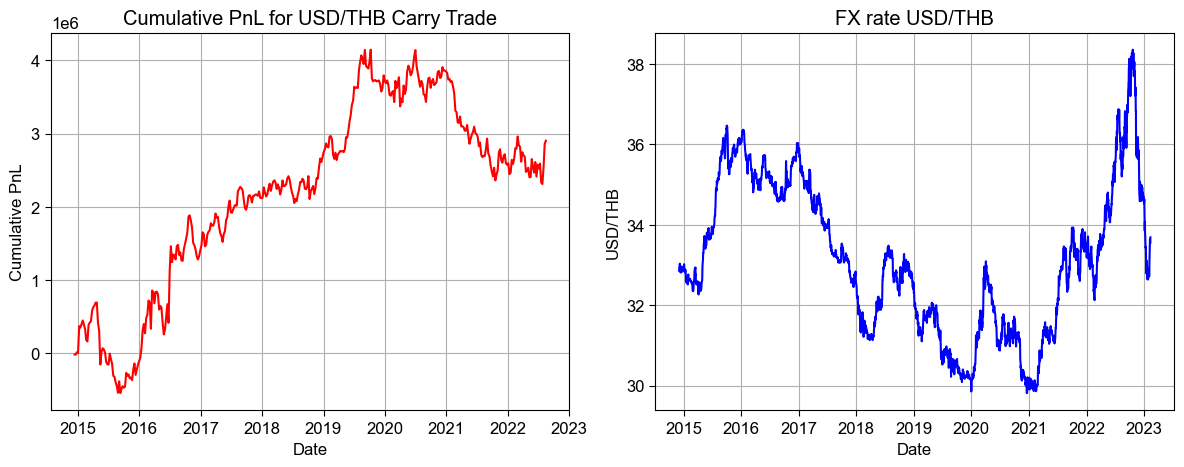

In [348]:
# Set the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot cumulative PnL
axs[0].plot(THB_Carry.index, THB_Carry['cumulative pnl'], color='red', label='Cumulative PnL')
axs[0].set_title("Cumulative PnL for USD/THB Carry Trade")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Cumulative PnL")
axs[0].grid(True)

# Plot RATE
axs[1].plot(thb.loc[pd.to_datetime('2014-12-03'):].index, thb.loc[pd.to_datetime('2014-12-03'):]['RATE'], color='blue', label='RATE')
axs[1].set_title("FX rate USD/THB")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("USD/THB")
axs[1].grid(True)

plt.tight_layout()
plt.show()

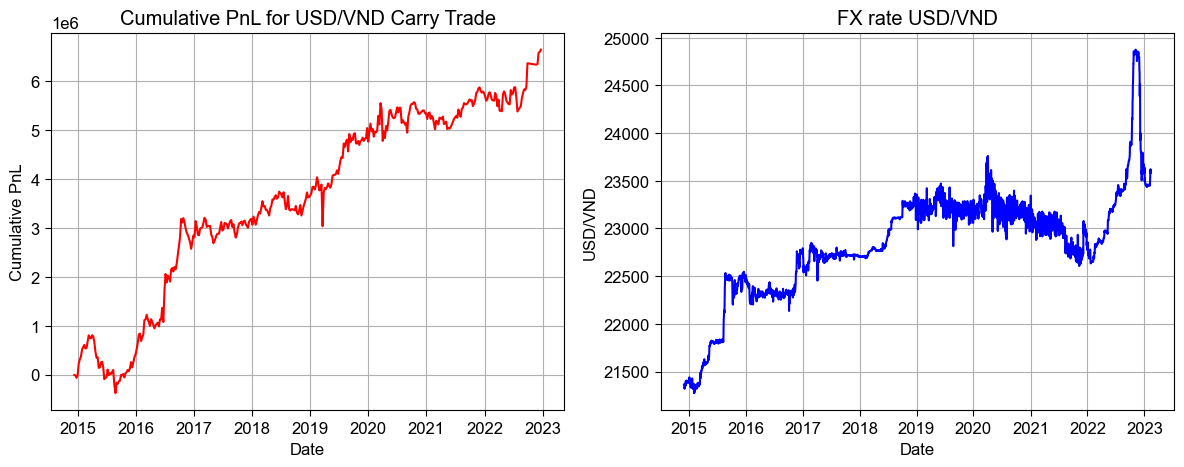

In [349]:
# Set the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot cumulative PnL
axs[0].plot(VND_Carry.index, VND_Carry['cumulative pnl'], color='red', label='Cumulative PnL')
axs[0].set_title("Cumulative PnL for USD/VND Carry Trade")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Cumulative PnL")
axs[0].grid(True)

# Plot RATE
axs[1].plot(vnd.loc[pd.to_datetime('2014-12-03'):].index, vnd.loc[pd.to_datetime('2014-12-03'):]['RATE'], color='blue', label='RATE')
axs[1].set_title("FX rate USD/VND")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("USD/VND")
axs[1].grid(True)

plt.tight_layout()
plt.show()

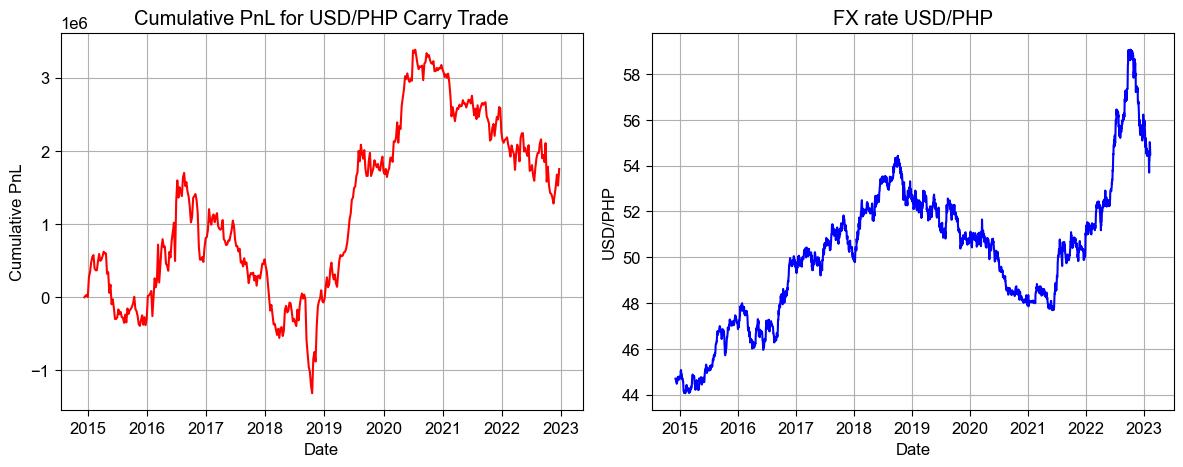

In [350]:
# Set the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot cumulative PnL
axs[0].plot(PHP_Carry.index, PHP_Carry['cumulative pnl'], color='red', label='Cumulative PnL')
axs[0].set_title("Cumulative PnL for USD/PHP Carry Trade")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Cumulative PnL")
axs[0].grid(True)

# Plot RATE
axs[1].plot(php.loc[pd.to_datetime('2014-12-03'):].index, php.loc[pd.to_datetime('2014-12-03'):]['RATE'], color='blue', label='RATE')
axs[1].set_title("FX rate USD/PHP")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("USD/PHP")
axs[1].grid(True)

plt.tight_layout()
plt.show()

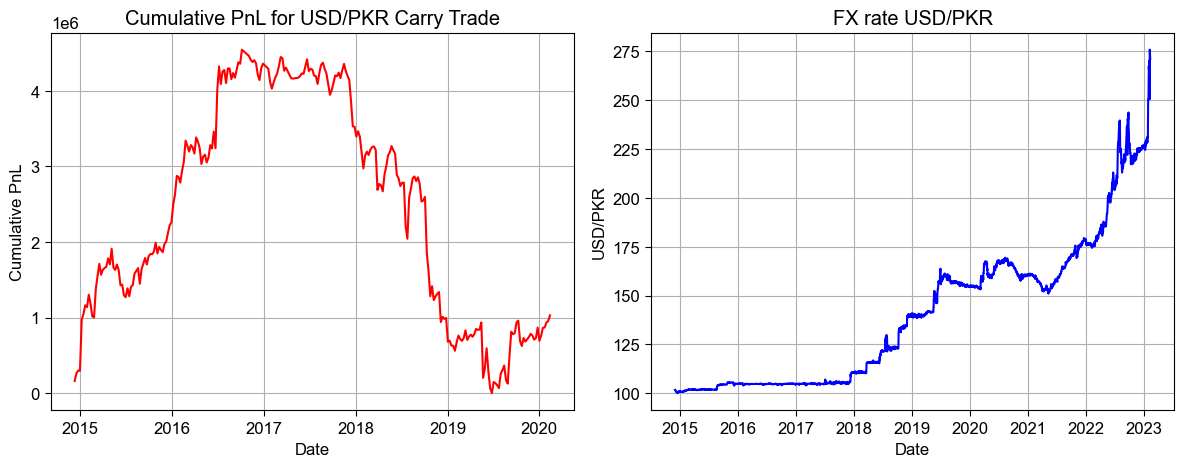

In [351]:
# Set the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot cumulative PnL
axs[0].plot(PKR_Carry.index, PKR_Carry['cumulative pnl'], color='red', label='Cumulative PnL')
axs[0].set_title("Cumulative PnL for USD/PKR Carry Trade")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Cumulative PnL")
axs[0].grid(True)

# Plot RATE
axs[1].plot(pkr.loc[pd.to_datetime('2014-12-03'):].index, pkr.loc[pd.to_datetime('2014-12-03'):]['RATE'], color='blue', label='RATE')
axs[1].set_title("FX rate USD/PKR")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("USD/PKR")
axs[1].grid(True)

plt.tight_layout()
plt.show()

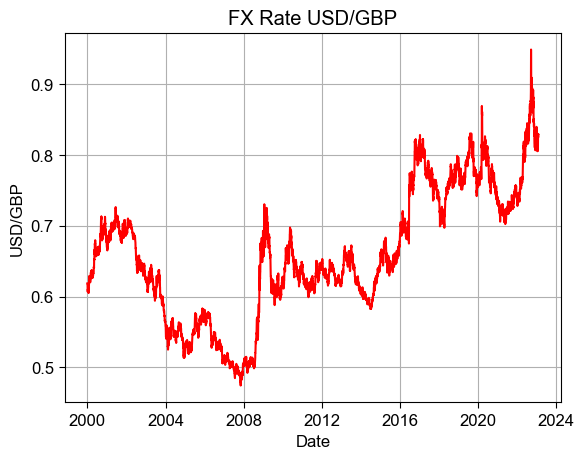

In [357]:
# Plot cumulative PnL
plt.plot(gbp.index, gbp['RATE'], color='red', label='Cumulative PnL')
plt.title("FX Rate USD/GBP")
plt.xlabel("Date")
plt.ylabel("USD/GBP")
plt.grid(True)
plt.show()